<a href="https://colab.research.google.com/github/hhandc/CompPrep/blob/main/Password_encrypt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment


In [1]:
!pip install face_recognition
!pip install opencv-python
!sudo apt-get install cmake
!pip install dlib
!pip install cryptography
!pip install dlib --no-binary :all:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=0049099001b3879b64606c783145df87dd495c744117f956776bbaff8b10a539
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Preprocess images quality

In [ ]:
import cv2
import numpy as np
import os

def process_image(image_path, output_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image: {image_path}")
        return

    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    lab = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged_lab = cv2.merge((cl, a, b))
    contrast_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(contrast_image, -1, kernel)

    cv2.imwrite(output_path, sharpened_image)

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Processing {filename}...")
            process_image(input_path, output_path)
        else:
            print(f"Skipping non-image file: {filename}")

if __name__ == "__main__":
    input_folder = "input_images"
    output_folder = "output_images"

    process_folder(input_folder, output_folder)

# Website Manager

In [ ]:
import json

website_random_strings = {
    "example.com": "a8K3Ld9X",
    "mywebsite.org": "b9P4Xm7N",
    "anotherwebsite.net": "p5C7Rt8V",
    "somedomain.com": "q1Z8Mn4S"
}

with open("websites.json", "w") as f:
    json.dump(website_random_strings, f, indent=4)

# Key generating process

In [16]:
import face_recognition
import numpy as np
import hashlib
import random
import string
from cryptography.fernet import Fernet
import base64
import json
import os

def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def extract_face_distances(image_path):
    image = face_recognition.load_image_file(image_path)
    face_landmarks_list = face_recognition.face_landmarks(image)

    if not face_landmarks_list:
        return None, None, "No faces detected in the image."

    face_landmarks = face_landmarks_list[0]

    left_eye = face_landmarks['left_eye']
    right_eye = face_landmarks['right_eye']

    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eye_distance = calculate_distance(left_eye_center, right_eye_center)

    chin = face_landmarks['chin']
    nose_bridge = face_landmarks['nose_bridge']

    forehead_point = nose_bridge[0]
    chin_point = chin[-1]

    forehead_to_chin_distance = calculate_distance(forehead_point, chin_point)

    normalized_forehead_to_chin = forehead_to_chin_distance / eye_distance

    return eye_distance, normalized_forehead_to_chin, None


def generate_random_string(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

def get_or_create_random_string(website, storage_file="websites.json"):
    if not os.path.exists(storage_file):
        with open(storage_file, "w") as f:
            json.dump({}, f)

    with open(storage_file, "r") as f:
        website_random_strings = json.load(f)

    if website in website_random_strings:
        print(website_random_strings[website])
        return website_random_strings[website]
    else:
        random_str = generate_random_string(8)
        website_random_strings[website] = random_str

        with open(storage_file, "w") as f:
            json.dump(website_random_strings, f)

        return random_str

def generate_encryption_key(image_path, website):
    eye_distance, forehead_to_chin_distance, error = extract_face_distances(image_path)

    if error:
        return None, error

    # Quantize distances
    eye_distance_quantized = round(eye_distance, 1)
    forehead_to_chin_quantized = round(forehead_to_chin_distance, 2)

    eye_distance_str = f"{eye_distance_quantized:.1f}"
    forehead_to_chin_distance_str = f"{forehead_to_chin_quantized:.2f}"

    combined_str = eye_distance_str + forehead_to_chin_distance_str

    random_str = get_or_create_random_string(website)
    combined_with_random = combined_str + random_str

    hashed_key = hashlib.sha256(combined_with_random.encode()).digest()
    encryption_key = base64.urlsafe_b64encode(hashed_key[:32])

    return encryption_key, None

def encrypt_password(password, encryption_key):
    fernet = Fernet(encryption_key)
    encrypted_password = fernet.encrypt(password.encode())

    return encrypted_password

def decrypt_password(encrypted_password, encryption_key):
    fernet = Fernet(encryption_key)
    decrypted_password = fernet.decrypt(encrypted_password).decode()

    return decrypted_password

image_path = input("Enter the path to the image file: ")
website = input("Enter the website you want to use this password: ")
encryption_key, error = generate_encryption_key(image_path, website)

if encryption_key:
    print("Encryption Key Generated Successfully!")
    password = input("Enter the password you want to encrypt: ")
    encrypted_password = encrypt_password(password, encryption_key)
    print("Encrypted Password:", encrypted_password)

    decrypted_password = decrypt_password(encrypted_password, encryption_key)
    print("Decrypted Password:", decrypted_password)
else:
    print(f"Error: {error}")

Enter the path to the image file: George_W_Bush.jpg
Enter the website you want to use this password: example.com
Encryption Key Generated Successfully!
Enter the password you want to encrypt: hello
Encrypted Password: b'gAAAAABnZVOmrsyvkcEy5BuJ1kC0S4ry7n43r-lzCIVMwbpl6OOEnvuN8oSypYD0o0sp849PDEhunMmYinTb7biqPe5sW2Ni-g=='
Decrypted Password: hello


In [21]:
import face_recognition
import numpy as np
import hashlib
import random
import string
from cryptography.fernet import Fernet
import base64
import json
import os

def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def extract_face_distances(image_path):
    image = face_recognition.load_image_file(image_path)
    face_landmarks_list = face_recognition.face_landmarks(image)

    if not face_landmarks_list:
        return None, None, "No faces detected in the image."

    face_landmarks = face_landmarks_list[0]

    left_eye = face_landmarks['left_eye']
    right_eye = face_landmarks['right_eye']

    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eye_distance = calculate_distance(left_eye_center, right_eye_center)

    chin = face_landmarks['chin']
    nose_bridge = face_landmarks['nose_bridge']

    forehead_point = nose_bridge[0]
    chin_point = chin[-1]

    forehead_to_chin_distance = calculate_distance(forehead_point, chin_point)

    normalized_forehead_to_chin = forehead_to_chin_distance / eye_distance

    return eye_distance, normalized_forehead_to_chin, None


def generate_random_string(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

def get_or_create_random_string(website, storage_file="websites.json"):
    if not os.path.exists(storage_file):
        with open(storage_file, "w") as f:
            json.dump({}, f)

    with open(storage_file, "r") as f:
        website_random_strings = json.load(f)

    if website in website_random_strings:
        print(website_random_strings[website])
        return website_random_strings[website]
    else:
        random_str = generate_random_string(8)
        website_random_strings[website] = random_str

        with open(storage_file, "w") as f:
            json.dump(website_random_strings, f)

        return random_str

def generate_encryption_key(image_path, website):
    eye_distance, forehead_to_chin_distance, error = extract_face_distances(image_path)

    if error:
        return None, error

    print("eye_distance: ")
    print(eye_distance)
    print("forehead_to_chin distance: ")
    print(forehead_to_chin_distance)
    # Quantize distances

    eye_distance_quantized = round(eye_distance, 1)
    forehead_to_chin_quantized = round(forehead_to_chin_distance, 2)

    eye_distance_str = f"{eye_distance_quantized:.1f}"
    forehead_to_chin_distance_str = f"{forehead_to_chin_quantized:.2f}"

    combined_str = eye_distance_str + forehead_to_chin_distance_str

    print(combined_str)

    random_str = get_or_create_random_string(website)

    print(random_str)

    combined_with_random = combined_str + random_str

    print(combined_with_random)

    hashed_key = hashlib.sha256(combined_with_random.encode()).digest()
    encryption_key = base64.urlsafe_b64encode(hashed_key[:32])

    return encryption_key, None

def encrypt_password(password, encryption_key):
    fernet = Fernet(encryption_key)
    encrypted_password = fernet.encrypt(password.encode())

    return encrypted_password

def decrypt_password(encrypted_password, encryption_key):
    fernet = Fernet(encryption_key)
    decrypted_password = fernet.decrypt(encrypted_password).decode()

    return decrypted_password

image_path = input("Enter the path to the image file: ")
website = input("Enter the website you want to use this password: ")
encryption_key, error = generate_encryption_key(image_path, website)

if encryption_key:
    print("Encryption Key Generated Successfully!")
    print(encryption_key)
    password = input("Enter the password you want to encrypt: ")
    encrypted_password = encrypt_password(password, encryption_key)
    print("Encrypted Password:", encrypted_password)

    decrypted_password = decrypt_password(encrypted_password, encryption_key)
    print("Decrypted Password:", decrypted_password)
else:
    print(f"Error: {error}")

Enter the path to the image file: George_W_Bush.jpg
Enter the website you want to use this password: example.com
eye_distance: 
43.349035616595785
forehead_to_chin distance: 
1.240136474968809
43.3
1.24
43.31.24
vWHU23AO
vWHU23AO
43.31.24vWHU23AO
Encryption Key Generated Successfully!
b'EU5ClTxE_8Vpt_Px0QtO2L5fubuyK1LXHNEmGflA7Sw='
Enter the password you want to encrypt: hello
Encrypted Password: b'gAAAAABnZVm_KVk3yJXF2EXrOG-Fn9m4vJpTFDb4eIcrIDU1oy0lToKMiHdcFUTw70nYYJPYfsYzDNwonsY7vEmmrIzz13GHAg=='
Decrypted Password: hello


In [ ]:
import face_recognition
import numpy as np
import hashlib
import random
import string
import json
import os
from cryptography.fernet import Fernet
import base64

def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def extract_face_distances(image_path):
    image = face_recognition.load_image_file(image_path)
    face_landmarks_list = face_recognition.face_landmarks(image)

    if not face_landmarks_list:
        return None, None, "No faces detected in the image."

    face_landmarks = face_landmarks_list[0]
    left_eye = face_landmarks['left_eye']
    right_eye = face_landmarks['right_eye']
    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eye_distance = calculate_distance(left_eye_center, right_eye_center)

    chin = face_landmarks['chin']
    nose_bridge = face_landmarks['nose_bridge']
    forehead_point = nose_bridge[0]
    chin_point = chin[-1]
    forehead_to_chin_distance = calculate_distance(forehead_point, chin_point)

    return eye_distance, forehead_to_chin_distance, None

def get_or_create_random_string(website, storage_file="website_random_strings.json"):
    if not os.path.exists(storage_file):
        with open(storage_file, "w") as f:
            json.dump({}, f)

    with open(storage_file, "r") as f:
        website_random_strings = json.load(f)

    if website in website_random_strings:
        return website_random_strings[website]
    else:
        random_str = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(8))
        website_random_strings[website] = random_str
        with open(storage_file, "w") as f:
            json.dump(website_random_strings, f)
        return random_str

def generate_encryption_key(image_path, website):
    eye_distance, forehead_to_chin_distance, error = extract_face_distances(image_path)
    if error:
        return None, error

    eye_distance_str = f"{eye_distance:.2f}"
    forehead_to_chin_distance_str = f"{forehead_to_chin_distance:.2f}"
    combined_str = eye_distance_str + forehead_to_chin_distance_str
    random_str = get_or_create_random_string(website)
    combined_with_random = combined_str + random_str
    print(combined_with_random)
    hashed_key = hashlib.sha256(combined_with_random.encode()).digest()
    encryption_key = base64.urlsafe_b64encode(hashed_key[:32])

    return encryption_key, None

def encrypt_password(password, encryption_key):
    fernet = Fernet(encryption_key)
    encrypted_password = fernet.encrypt(password.encode())
    return encrypted_password

def calculate_consistency(image_folder, website, password):
    encrypted_passwords = []
    consistent_count = 0
    total_images = 0

    for filename in os.listdir(image_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_folder, filename)
            encryption_key, error = generate_encryption_key(image_path, website)
            if encryption_key:
                encrypted_password = encrypt_password(password, encryption_key)
                print(encrypted_password)
                encrypted_passwords.append(encrypted_password)
                total_images += 1

    if total_images > 0:
        first_password = encrypted_passwords[0]
        consistent_count = sum(1 for ep in encrypted_passwords if ep == first_password)
        consistency_rate = (consistent_count / total_images) * 100
        accuracy = "Consistent" if consistent_count == total_images else "Inconsistent"

        print(f"Consistency Rate: {consistency_rate:.2f}%")
        print(f"Accuracy: {accuracy}")
    else:
        print("No valid images found for processing.")

# Example usage
image_folder = input("Enter the path to the folder of images: ")
website = input("Enter the website URL: ")
password = input("Enter the password you want to encrypt: ")

calculate_consistency(image_folder, website, password)

Enter the path to the folder of images: image5
Enter the website URL: example.com
Enter the password you want to encrypt: 1234
554.23690.160hIiyIJy
b'gAAAAABnJ6LdhE9qOk8tiDiy4EZitbwdQYNEuRI420hxwqnlDo6mLIFOT-aKplDgrZIP7Jr5QvR18w7c7gAzRutsoYdnUro4ag=='
554.23690.160hIiyIJy
b'gAAAAABnJ6Lhvfdzug_P5pj-EUMIxS9Mjbn9zPCxS7VMED4JyolPjKxppAUR-LZ1wLO0HsIeRYm2CpRz23aUGiX5mJOvjTvC_A=='
Consistency Rate: 50.00%
Accuracy: Inconsistent


In [14]:
import face_recognition
import numpy as np
import hashlib
import random
import string
import json
import os
from cryptography.fernet import Fernet
import base64

def get_or_create_random_string(website, storage_file="website_random_strings.json"):
    if not os.path.exists(storage_file):
        with open(storage_file, "w") as f:
            json.dump({}, f)

    with open(storage_file, "r") as f:
        website_random_strings = json.load(f)

    if website in website_random_strings:
        return website_random_strings[website]
    else:
        random_str = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(8))
        website_random_strings[website] = random_str
        with open(storage_file, "w") as f:
            json.dump(website_random_strings, f)
        return random_str

def generate_encryption_key_from_embedding(image_path, website):
    image = face_recognition.load_image_file(image_path)
    embeddings = face_recognition.face_encodings(image)

    if not embeddings:
        return None, "No face detected."

    embedding = embeddings[0]

    embedding_str = ''.join(f"{value:.5f}" for value in embedding)

    random_str = get_or_create_random_string(website)
    combined_str = embedding_str + random_str

    hashed_key = hashlib.sha256(combined_str.encode()).digest()[:32]
    encryption_key = base64.urlsafe_b64encode(hashed_key).decode('utf-8')
    encryption_key = encryption_key[:32].ljust(32, '=')

    return encryption_key.encode(), None

def encrypt_password(password, encryption_key):
    fernet = Fernet(encryption_key)
    encrypted_password = fernet.encrypt(password.encode())
    return encrypted_password

def decrypt_password(encrypted_password, encryption_key):
    fernet = Fernet(encryption_key)
    decrypted_password = fernet.decrypt(encrypted_password).decode()
    return decrypted_password

def calculate_consistency(image_folder, website, password):
    encrypted_passwords = []
    total_images = 0

    for filename in os.listdir(image_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_folder, filename)
            encryption_key, error = generate_encryption_key_from_embedding(image_path, website)

            if error:
                print(f"Error for {filename}: {error}")
                continue

            encrypted_password = encrypt_password(password, encryption_key)
            encrypted_passwords.append(encrypted_password)
            total_images += 1

    if total_images > 0:
        first_password = encrypted_passwords[0]
        consistent_count = sum(1 for ep in encrypted_passwords if ep == first_password)
        consistency_rate = (consistent_count / total_images) * 100
        accuracy = "Consistent" if consistent_count == total_images else "Inconsistent"

        print(f"Consistency Rate: {consistency_rate:.2f}%")
        print(f"Accuracy: {accuracy}")
    else:
        print("No valid images found for processing.")

image_folder = input("Enter the path to the folder of images: ")
website = input("Enter the website URL: ")
password = input("Enter the password you want to encrypt: ")

calculate_consistency(image_folder, website, password)

Enter the path to the folder of images: George_W_Bush.jpg
Enter the website URL: example.com
Enter the password you want to encrypt: hello


FileNotFoundError: [Errno 2] No such file or directory: 'George_W_Bush.jpg'

# Testing and Image generation for paper

In [ ]:
import face_recognition
import cv2

def extract_face_features(image_path):
    image = face_recognition.load_image_file(image_path)
    face_landmarks_list = face_recognition.face_landmarks(image)

    if not face_landmarks_list:
        return "No faces detected in the image."

    for face_landmarks in face_landmarks_list:
        face_features_str = "Facial Features:\n"
        for feature, points in face_landmarks.items():
            face_features_str += f"{feature}: {points}\n"
        return face_features_str

image_path = input("Enter the path to the image file: ")
features = extract_face_features("selfie.jpg")
print(features)

KeyboardInterrupt: Interrupted by user

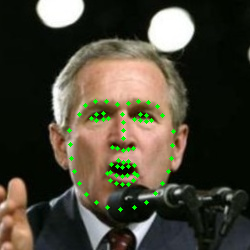

Image with landmarks saved to output_with_landmarks.jpg


In [6]:
import face_recognition
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import cv2_imshow from google.colab.patches


image_path = "George_W_Bush.jpg"
output_image_path = "output_with_landmarks.jpg"

image = face_recognition.load_image_file(image_path)

face_landmarks_list = face_recognition.face_landmarks(image)

image_with_landmarks = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

def draw_landmarks(image, landmarks):
    for face_landmarks in landmarks:
        for feature, points in face_landmarks.items():
            for point in points:
                cv2.circle(image, point, 2, (0, 255, 0), -1)  # Green circles

draw_landmarks(image_with_landmarks, face_landmarks_list)

cv2.imwrite(output_image_path, image_with_landmarks)

cv2_imshow(image_with_landmarks) # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Image with landmarks saved to {output_image_path}")

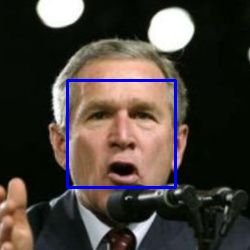

Image with detected faces saved to output_detected_faces.jpg


In [4]:
import face_recognition
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

image_path = "George_W_Bush.jpg"
output_image_path = "output_detected_faces.jpg"

image = face_recognition.load_image_file(image_path)

face_locations = face_recognition.face_locations(image)

image_with_detections = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

for top, right, bottom, left in face_locations:
    cv2.rectangle(image_with_detections, (left, top), (right, bottom), (255, 0, 0), 2)

cv2.imwrite(output_image_path, image_with_detections)

cv2_imshow(image_with_detections)  # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Image with detected faces saved to {output_image_path}")

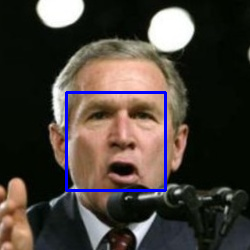

Image with detected faces saved to output_detected_faces_cnn.jpg


In [6]:
import face_recognition
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

image_path = "George_W_Bush.jpg"
output_image_path = "output_detected_faces_cnn.jpg"

image = face_recognition.load_image_file(image_path)

face_locations = face_recognition.face_locations(image, model="cnn")

image_with_detections = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

for top, right, bottom, left in face_locations:
    cv2.rectangle(image_with_detections, (left, top), (right, bottom), (255, 0, 0), 2)

cv2.imwrite(output_image_path, image_with_detections)

# Replace cv2.imshow() with cv2_imshow()
cv2_imshow(image_with_detections)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Image with detected faces saved to {output_image_path}")

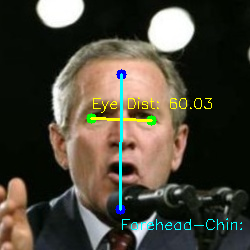

Image with landmarks and distances saved to output_landmarks_distances.jpg


In [11]:
import face_recognition
import cv2
from google.colab.patches import cv2_imshow

# Load the image file
image_path = "George_W_Bush.jpg"  # Replace with the path to your image
output_image_path = "output_landmarks_distances.jpg"

# Load the image using face_recognition
image = face_recognition.load_image_file(image_path)

# Find facial landmarks in the image
face_landmarks_list = face_recognition.face_landmarks(image)

# Convert the image to a format compatible with OpenCV
image_with_landmarks = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Process each face found in the image
for face_landmarks in face_landmarks_list:
    # Get the coordinates of the specific landmarks
    left_eye_center = face_landmarks["left_eye"][0]
    right_eye_center = face_landmarks["right_eye"][3]
    chin = face_landmarks["chin"][8]

    eye_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    forehead = (
        eye_midpoint[0],
        eye_midpoint[1] - (chin[1] - eye_midpoint[1]) // 2  # Adjust the offset as needed
    )

    eye_distance = ((right_eye_center[0] - left_eye_center[0]) ** 2 +
                    (right_eye_center[1] - left_eye_center[1]) ** 2) ** 0.5
    forehead_to_chin_distance = ((chin[0] - forehead[0]) ** 2 +
                                 (chin[1] - forehead[1]) ** 2) ** 0.5

    cv2.circle(image_with_landmarks, left_eye_center, 5, (0, 255, 0), -1)
    cv2.circle(image_with_landmarks, right_eye_center, 5, (0, 255, 0), -1)
    cv2.circle(image_with_landmarks, chin, 5, (255, 0, 0), -1)
    cv2.circle(image_with_landmarks, forehead, 5, (255, 0, 0), -1)

    cv2.line(image_with_landmarks, left_eye_center, right_eye_center, (0, 255, 255), 2)
    cv2.line(image_with_landmarks, chin, forehead, (255, 255, 0), 2)

    cv2.putText(image_with_landmarks, f"Eye Dist: {eye_distance:.2f}",
                (left_eye_center[0], left_eye_center[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
    cv2.putText(image_with_landmarks, f"Forehead-Chin: {forehead_to_chin_distance:.2f}",
                (chin[0], chin[1] + 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

cv2.imwrite(output_image_path, image_with_landmarks)

# Replace cv2.imshow() with cv2_imshow() for Colab compatibility:
cv2_imshow(image_with_landmarks)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Image with landmarks and distances saved to {output_image_path}")